# ABIDE Subtype analysis
Lazy man result overview for anything

In [1]:
# Imports
import os
import glob
import time
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.sandbox.stats import multicomp as smi

In [2]:
%matplotlib inline

# Paths

In [3]:
# Variables
subtypes = 5
cov = 'EYE_STATUS_AT_SCAN'#'ADOS_SOCOM_SEV'
scale = 7
mtp = 'rmap_part'
name = 'site_279_sample'
pheno_path = '/data1/abide/Pheno/site_balanced_279.csv'

# Fixed values
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
in_path = '/data1/subtypes/serial_preps/'

netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))

In [4]:
# Network name lookup table
sc7_names = [
             'Cerebellum',
             'Limbic',
             'Somatomotor',
             'Visual',
             'Default Mode',
             'Frontoparietal',
             'Ventral Attention'
            ]
sc12_names = [
              'Basal Ganglia',
              'Auditory',
              'Limbic',
              'Lateral Default Mode',
              'Visual',
              'Posterior medial Default Mode',
              'Somatomotor',
              'Anterior Default Mode',
              'Dorsal Attention',
              'Frontoparietal',
              'Ventral Attention',
              'Cerebellum'
              ]

In [5]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [6]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)

In [7]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [8]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

# Define some functions and the niak colormap

In [9]:
# Define the allrounder function
def get_data(scale, maptype, name, subtypes, cov, pheno):
    # Get the paths
    netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(maptype, name, scale))
    netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(maptype, name, scale))
    corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(maptype, name, scale))
    # Get the files
    netstack = np.load(netstack_path)
    corr_mat = np.load(corrmat_path)
    
    # Make the subtypes
    subtypes = 5
    scale = netstack.shape[0]
    n_sub = netstack.shape[2]
    n_vox = netstack.shape[1]

    link_store = np.zeros((n_sub-1,4,scale))
    part_store = np.zeros((scale, n_sub))
    sbt_store = np.zeros((scale, subtypes, n_vox))
    weight_store = np.zeros((scale, subtypes, n_sub))
    
    # Iterate through the networks
    for net_id in range(scale):
        # Compute linkage with Ward's criterion
        link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
        link_store[..., net_id] = link_mat
        # Partition the linkage to get a given number of subtypes
        part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
        part_store[net_id, :] = part_sub

        sub_stack = np.zeros((n_vox, subtypes))
        for s_id in range(subtypes):
            sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
            sub_stack[:,s_id] = sbt
            sbt_store[net_id, s_id, :] = sbt

        # Init store - Compute the weights
        for s_id in range(subtypes):
            type_map = sub_stack[:, s_id]
            weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])
            
    # Run the GLM
    # Get the subjects that have the covariate
    cov_index = pd.notnull(pheno[cov])
    cov_pheno = pheno[cov_index]
    # Generate the model matrix
    factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
    # Make dummy variables for the site factor
    site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
    # Turn the first site into the intercept
    site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
    site_factor['INTERCEPT'] = 1
    # Get the other variables
    other_factors = cov_pheno.ix[:,factors]
    # Turn diagnosis into [0,1] vector
    if cov == 'DX_GROUP':
        other_factors[cov] = other_factors[cov].values - 1
    else:
        # Demean the covariate
        other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)

    # Demean age
    other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
    # Put them back together
    glm_pheno = pd.concat([site_factor, other_factors], axis=1)
    # Get the weights for these subjects
    cov_weight = weight_store[..., cov_index.values]

    # Prepare storage variables
    res_store = list()
    pval_store = np.zeros((scale, subtypes))
    for net_id in range(scale):
        res_list = list()
        # Loop through the subtypes
        for s_id in range(subtypes):
            model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
            results = model.fit()
            # Save the p-values
            pval_store[net_id, s_id] = results.pvalues[cov]
            res_list.append(results)
        res_store.append(res_list)
    # Now look at the mask of p-values passing FDR Correction
    pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
    pcorr_vec = smi.multipletests(pval_vec.flatten(), alpha=0.05, method='fdr_bh')
    pcorr = np.reshape(pcorr_vec[1], pval_store.shape)
    pthresh = np.reshape(pcorr_vec[0], pval_store.shape)

    return (corr_mat, weight_store, sbt_store, res_store, pthresh)

In [10]:
def show_network(network, corr_mat, weight_store, sbt_store, res_store, pthresh, cov, name_list, vr=0.1):
    # Setup the text overlay
    font = {'family': 'serif',
        'color':  'lime',
        'weight': 'heavy',
        'size': 18,
        }
    txt_offset=8
    # First find the hits
    net_hits, sbt_hits = np.where(pthresh)
    if not net_hits.size:
        return 'nothing significant'
    # Show the results for this network
    link_mat = scl.hierarchy.linkage(corr_mat[network, ...] , method='ward')
    ind = scl.hierarchy.dendrogram(link_mat, no_plot=True)['leaves']
    tmp = corr_mat[network, ...]
    show_mat = tmp[ind, :][:, ind]
   
    cov_index = pd.notnull(pheno[cov])
    cov_val = pheno[cov_index][cov].values
    # Get the subtypes with significant results for 
    # the current network
    sbts = sbt_hits[net_hits==network]
    # Number of subtypes to show
    n_sbts = len(sbts)
    n_figs = n_sbts+1
    
    # Prepare the figure
    fig = plt.figure(figsize=(25,6*n_figs))
    gs = gridspec.GridSpec(n_figs, 4)
    
    # Prepare the partition overlay
    part_test = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')[ind]
    part_frame = np.zeros(show_mat.shape)
    text_loc = list()
    for sbt_id in np.arange(subtypes):
        # Get first and last element
        hits = np.where(part_test==sbt_id+1)[0]
        first = hits[0]
        last = hits[-1]
        text_loc.append((len(hits)/2 + first-txt_offset, len(hits)/2 + first+txt_offset))
        # Draw column
        part_frame[first:last, (first, last)] = 1
        # Draw rows
        part_frame[(first, last), first:last] = 1
    part_frame = np.ma.masked_where(part_frame == 0, part_frame)
    
    # Start plotting
    ax1a = fig.add_subplot(gs[0, 0])
    ax1a.matshow(show_mat, vmin=-vr, vmax=vr, cmap=bb.visu.hot_cold())
    ax1a.matshow(part_frame, cmap=plt.cm.Greys)
    for sbt_id in np.arange(subtypes):
        (x,y) = text_loc[sbt_id]
        ax1a.text(x,y,'{}'.format(sbt_id), fontdict=font)

    ax1b = fig.add_subplot(gs[0, 1:])
    nlp.plot_glass_brain(nil.image.index_img(prior_img, network), cmap=plt.cm.spectral, 
                                 colorbar=False, vmin=1, vmax=scale,axes=ax1b,
                                title='{} Network'.format(name_list[network]))
    # Go through the findings
    for pid, sbt in enumerate(sbts):
        ax2a = fig.add_subplot(gs[pid+1, 0])
        # Get the sbt weights
        sbt_w = weight_store[network, sbt, cov_index.values]
        # Plot these over the covariate
        ax2a.scatter(cov_val, sbt_w)
        ax2b = fig.add_subplot(gs[pid+1, 1:])
        # Get the corresponding GLM result
        res = res_store[network][sbt]
        # Get sbt t-value
        sbt_t = res.tvalues[cov]
        # code orientation
        if sbt_t < 0:
            orient = 'negative'
        else: 
            orient = 'positive'
        # Show the subtype
        sbt_map = sbt_store[network, sbt,:]
        tmp = np.zeros_like(mask, dtype=np.float)
        tmp[mask] = sbt_map
        sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
        nlp.plot_stat_map(sbt_img, display_mode='x', threshold=0, 
                      cut_coords=[-50, -30, -10, 10, 30, 50], black_bg=True,axes=ax2b,
                         title='{} {} with sbt {} @ {} Network (T={:.2f})'.format(cov, orient, sbt, name_list[network], sbt_t))
    return net_hits

## Start looking at the results

In [11]:
corr_mat, weight_store, sbt_store, res_store, pthresh = get_data(scale, mtp, name, 5, cov, pheno)

In [12]:
# Take a look at the findings
np.where(pthresh)

(array([1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 6, 6]),
 array([0, 1, 4, 0, 1, 2, 3, 4, 0, 1, 2, 4, 0, 3]))

## Cerebellar Network (0)

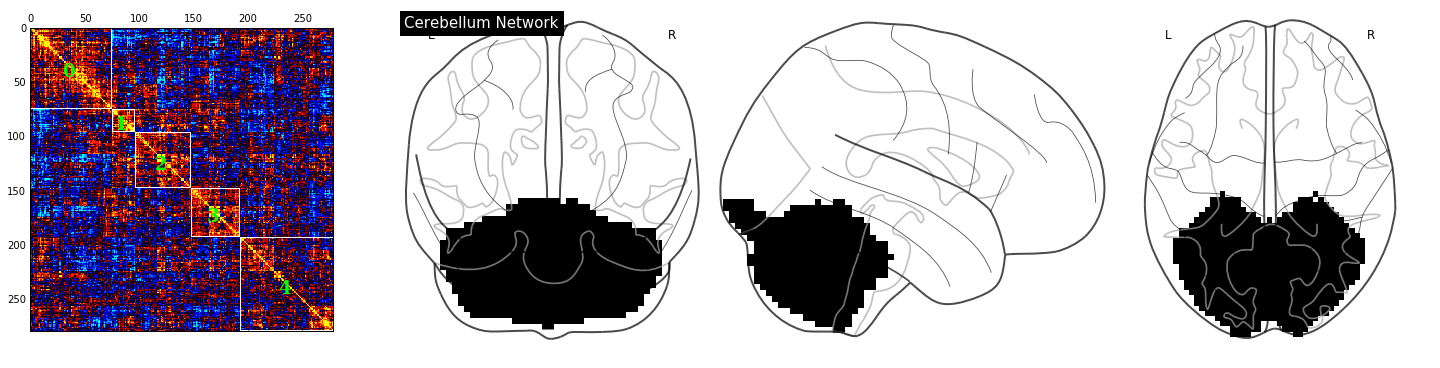

In [13]:
tmp = show_network(0, corr_mat, weight_store, sbt_store, res_store, pthresh, cov, sc7_names, vr=0.2)

Subtype 1 shows marked hypoconnectivity with the occipital cortex and parts of the cerebellum (within network dysconnectivity?) but hyperconnectivity with areas  of the posterior cingulate cortex and precuneus as well as dorsal medial prefrontal cortex. This pattern of altered connectivity is associated with __higher__ symptom severity.

Subtype 3 on the other hand shows patterns of above average connectivity with areas along the border of the brain, including cuneus, and medial prefrontal cortex. This looks a lot like a motion artifact map. This type of connectivity is associated with __lower__ symptom severity.

## Somatomotor network (2)

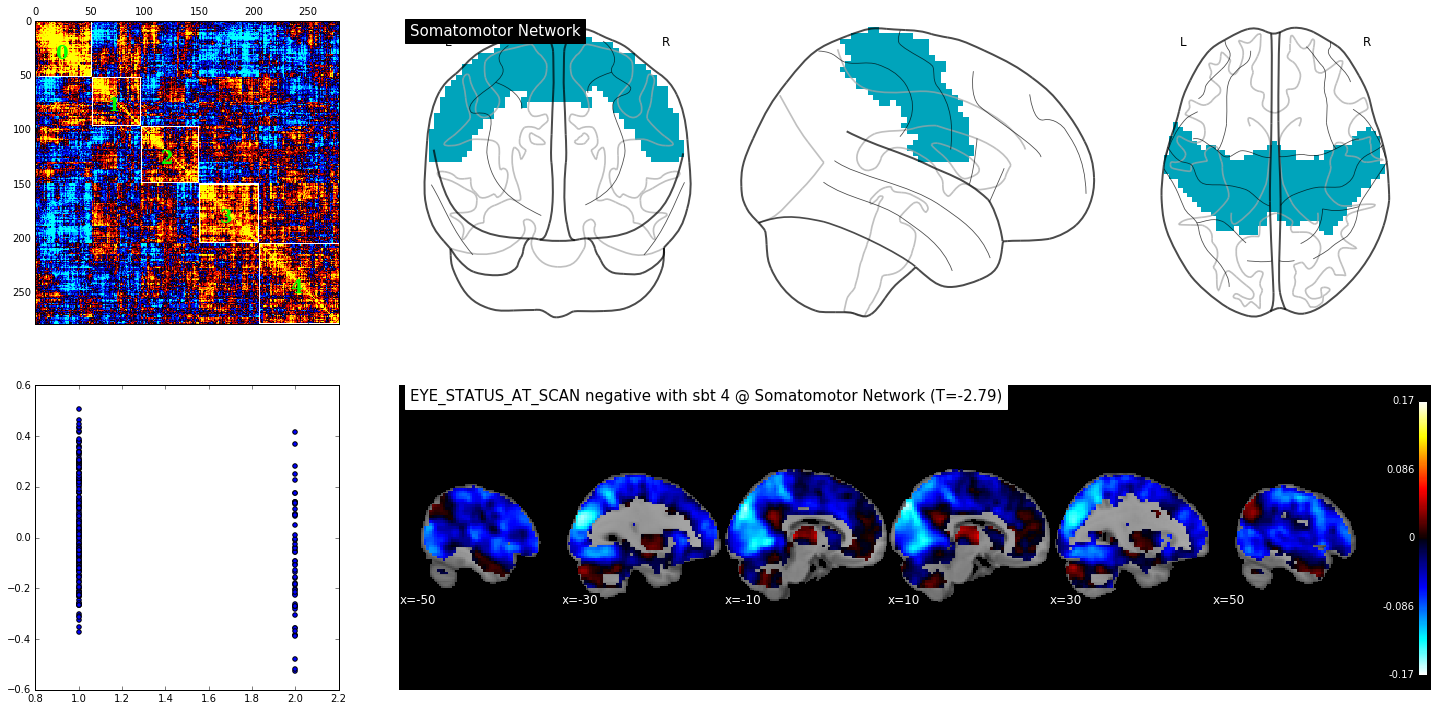

In [14]:
tmp = show_network(2, corr_mat, weight_store, sbt_store, res_store, pthresh, cov, sc7_names, vr=0.2)

Subtype 0 shows increased connectivity within the somatosensory network (the prior) and also with what looks like higher visual areas along both the ventral and dorsal stream. This type of pattern is associated with __increased__ symptom severity.